## Backtest Example Notebook

The purpose of this notebook is to illustrate how to use the `Backtest` class to do the back-testing. To have the greatest flexibility, this engine is designed to work for any model objects which have a `fit` method and a `predict` method, by writing some call back functions. The default settings work for **Orbit** model object automatically. Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

# import sys

# sys.path.append("../../orbit")
from orbit.lgt import LGT
from orbit.dlt import DLT
# from orbit.backtest import BacktestEngine
from orbit.backtest.backtest import Backtest
from orbit.utils.metrics import mape, smape, wmape
# from orbit.backtest import run_group_backtest, get_scores

## Load data

In [2]:
data_path = "../examples/data/iclaims.example.csv"
raw_data = pd.read_csv(data_path, parse_dates=['week'])

## log transformation
data = raw_data.copy()
# data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
#     data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)

print(data.shape)
data.head(5)

(443, 5)


week  claims  trend.unemploy  trend.filling  trend.job
0 2010-01-03  651215        1.183973       0.720140   1.119669
1 2010-01-10  825891        1.183973       0.814896   1.178599
2 2010-01-17  659173        1.203382       0.739091   1.119669
3 2010-01-24  507651        1.164564       0.814896   1.107883
4 2010-01-31  538617        1.086926       0.776993   1.072525

## Orbit model object

###  expanding window

Below we create a `Backtest` instance with expanding window

In [3]:
date_col = 'week'
response_col = 'claims'
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

min_train_len = 300
forecast_len = 20
incremental_len = 20

# bt_expand = BacktestEngine(mod, data)
bt_expand = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len
)

Then, instantiate a model that we want to backtest

In [9]:
mod = LGT(date_col = date_col,
    response_col = response_col,
    regressor_col = regressor_col,
    seasonality = 52,
    seed = 8888,
    predict_method = 'map',
    auto_scale=True
)

This function will fit the model and computed the desired metrics

In [10]:
bt_expand.fit_score(mod, response_col='claims', predicted_col='prediction')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_084901310495613f9d9442fb54aa98b8 NOW.


Retrieve raw predictions for every split

In [11]:
bt_expand.get_predictions().head()

steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2015-10-04  227176        1.261611       0.966504   1.072525   
1      2 2015-10-11  256522        1.319839       1.042308   1.025381   
2      3 2015-10-18  232860        1.261611       1.042308   1.037167   
3      4 2015-10-25  245365        1.261611       0.985455   1.025381   
4      5 2015-11-01  258440        1.281020       0.966504   1.060739   

      prediction  split_key  
0  246891.905818          0  
1  265551.882467          0  
2  246232.873646          0  
3  257076.419476          0  
4  256647.479963          0

Retrieve scores. For a single model, the scores are scalars in a dict

In [12]:
bt_expand.get_scores()

wmape     smape
0  0.050702  0.051309

### rolling window

In [13]:
# bt_expand = BacktestEngine(mod, data)
bt_roll = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    scheme='rolling'
)

bt_roll.fit_score(mod, response_col='claims', predicted_col='prediction')
bt_roll.get_predictions().head()

steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2015-10-04  227176        1.261611       0.966504   1.072525   
1      2 2015-10-11  256522        1.319839       1.042308   1.025381   
2      3 2015-10-18  232860        1.261611       1.042308   1.037167   
3      4 2015-10-25  245365        1.261611       0.985455   1.025381   
4      5 2015-11-01  258440        1.281020       0.966504   1.060739   

      prediction  split_key  
0  246891.905818          0  
1  265551.882467          0  
2  246232.873646          0  
3  257076.419476          0  
4  256647.479963          0

In [14]:
bt_roll.get_scores()

wmape     smape
0  0.050965  0.051381

### using number of trainings

User can also define number of trainings using `n_train` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [15]:
# bt_expand = BacktestEngine(mod, data)
bt_n_split = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    n_splits=2,
    scheme='rolling'
)

bt_n_split.fit_score(mod, response_col='claims', predicted_col='prediction')
bt_n_split.get_predictions().head()

steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2017-09-24  212987        1.048107       1.042308   0.990023   
1      2 2017-10-01  204180        1.067517       1.023357   0.966451   
2      3 2017-10-08  229241        1.086926       1.061259   1.013595   
3      4 2017-10-15  205592        1.106335       1.080210   0.966451   
4      5 2017-10-22  216004        1.086926       1.080210   0.978237   

      prediction  split_key  
0  194701.971782          0  
1  201454.936843          0  
2  234461.470566          0  
3  226562.325608          0  
4  232351.534459          0

In [16]:
bt_n_split.get_scores()

wmape    smape
0  0.052307  0.05161

## Sklearn model object - Random Forest

We can generalize backtest to other model objects using callback functions

In [18]:
from sklearn.ensemble import RandomForestRegressor

# custom callback
def fit_callback_sklearn(model, train_df, response_col, regressor_col):
    y = train_df[response_col]
    X = train_df[regressor_col]
    model.fit(X, y)
    return

def predict_callback_sklearn(model, test_df, response_col, regressor_col):
    X = test_df[regressor_col]
    pred = model.predict(X)

    return pd.DataFrame(pred, columns=['prediction'])

Next, instantiate an sklearn model

In [19]:
mod = RandomForestRegressor(n_estimators = 50)

In [23]:
# bt_expand = BacktestEngine(mod, data)
bt_sklearn = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
)

fit_args_rf = {
    'response_col': 'claims',
    'regressor_col': ['trend.unemploy', 'trend.filling', 'trend.job']
}

bt_sklearn.fit_score(
    mod,
    response_col='claims',
    predicted_col='prediction',
    fit_callback=fit_callback_sklearn,
    predict_callback=predict_callback_sklearn,
    fit_args=fit_args_rf
)

bt_sklearn.get_predictions().head()

   steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2015-10-04  227176        1.261611       0.966504   1.072525   
1      2 2015-10-11  256522        1.319839       1.042308   1.025381   
2      3 2015-10-18  232860        1.261611       1.042308   1.037167   
3      4 2015-10-25  245365        1.261611       0.985455   1.025381   
4      5 2015-11-01  258440        1.281020       0.966504   1.060739   

   prediction  split_key  
0   217182.42          0  
1   224077.58          0  
2   222731.44          0  
3   222337.68          0  
4   216279.42          0  


steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2015-10-04  227176        1.261611       0.966504   1.072525   
1      2 2015-10-11  256522        1.319839       1.042308   1.025381   
2      3 2015-10-18  232860        1.261611       1.042308   1.037167   
3      4 2015-10-25  245365        1.261611       0.985455   1.025381   
4      5 2015-11-01  258440        1.281020       0.966504   1.060739   

   prediction  split_key  
0   217182.42          0  
1   224077.58          0  
2   222731.44          0  
3   222337.68          0  
4   216279.42          0

In [24]:
bt_sklearn.get_scores()

wmape    smape
0  0.271442  0.22531

## Prophet model object

In [7]:
from fbprophet import Prophet
import inspect

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [8]:
def model_callback_prophet(model, **kwargs):
    object_type = type(model)
    new_instance = object_type(**kwargs)
    
    return new_instance

def fit_callbacks_prophet(model, train_df, date_col, response_col, regressor_col):
    
    train_df = train_df.rename(columns={date_col: "ds", response_col: "y"})
    if regressor_col is not None:
        for regressor in regressor_col:
            model.add_regressor(regressor) 
    model.fit(train_df)
    
    return 

# def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
#     test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
#     return model.predict(test_df)
# also, we an use predict callbacks to make the columns
# align across models. This wasn't necessary within only prophet models
# because the columns aligned
def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
    test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
    predictions = model.predict(test_df)
    predictions.rename(columns={'yhat': 'prediction', 'ds': date_col}, inplace=True)
    predictions=predictions[[date_col, 'prediction']]

    return predictions

In [12]:
# prophet standalone
mod = Prophet()
# fit_callbacks_prophet(
#     mod, data, date_col='week',
#     response_col='claims',
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job']
# )

# pred = pred_callbacks_prophet(
#     mod, data, date_col='week',
#     response_col='claims',
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job']
# )

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
# bt_expand = BacktestEngine(mod, data)
bt_prophet = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
)

fit_args_prophet = {
    'response_col': 'claims',
    'date_col': 'week',
    'regressor_col': ['trend.unemploy', 'trend.filling', 'trend.job']
}

bt_prophet.fit_score(
    mod,
    response_col='claims',
    predicted_col='prediction',
    fit_callback=fit_callbacks_prophet,
    predict_callback=pred_callbacks_prophet,
    model_callback=model_callback_prophet,
    fit_args=fit_args_prophet
)

bt_prophet.get_predictions().head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

   steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2015-10-04  227176        1.261611       0.966504   1.072525   
1      2 2015-10-11  256522        1.319839       1.042308   1.025381   
2      3 2015-10-18  232860        1.261611       1.042308   1.037167   
3      4 2015-10-25  245365        1.261611       0.985455   1.025381   
4      5 2015-11-01  258440        1.281020       0.966504   1.060739   

      prediction  split_key  
0  224395.896128          0  
1  239577.121819          0  
2  256718.823374          0  
3  258606.220632          0  
4  259758.275500          0  


steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2015-10-04  227176        1.261611       0.966504   1.072525   
1      2 2015-10-11  256522        1.319839       1.042308   1.025381   
2      3 2015-10-18  232860        1.261611       1.042308   1.037167   
3      4 2015-10-25  245365        1.261611       0.985455   1.025381   
4      5 2015-11-01  258440        1.281020       0.966504   1.060739   

      prediction  split_key  
0  224395.896128          0  
1  239577.121819          0  
2  256718.823374          0  
3  258606.220632          0  
4  259758.275500          0

In [15]:
bt_prophet.get_scores()

wmape     smape
0  0.086301  0.088464

## Backtest Multiple Models

`Backtest` has built in functionality to handle backtesting of multiple models. This can be multiple models with varying hyperparamters, or even different models all together, by using callbacks.

In [16]:
bt = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    n_splits=2,
    scheme='rolling'
)

Init a few different models, some with and some without callbacks

In [25]:
# lgt
lgt = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    chains=4,
    predict_method='map',
    seed=2020
)

# sklearn model rf
rf = RandomForestRegressor(n_estimators=50)

# prophet
prophet = Prophet()

In [26]:
# # also, we an use predict callbacks to make the columns
# # align across models. This wasn't necessary within only prophet models
# # because the columns aligned
# def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
#     test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
#     predictions = model.predict(test_df)
#     predictions.rename(columns={'yhat': 'prediction', 'ds': date_col}, inplace=True)
#     predictions=predictions[[date_col, 'prediction']]

#     return predictions

In [27]:
# batch fit and score models
bt.fit_score_batch(
    models=[lgt, rf, prophet],
    response_col='claims',
    predicted_col='prediction',
    fit_callbacks=[None, fit_callback_sklearn, fit_callbacks_prophet],
    predict_callbacks=[None, predict_callback_sklearn, pred_callbacks_prophet],
    model_callbacks=[None, None, model_callback_prophet],
    fit_args=[{}, fit_args_rf, fit_args_prophet]
)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


   steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2017-09-24  212987        1.048107       1.042308   0.990023   
1      2 2017-10-01  204180        1.067517       1.023357   0.966451   
2      3 2017-10-08  229241        1.086926       1.061259   1.013595   
3      4 2017-10-15  205592        1.106335       1.080210   0.966451   
4      5 2017-10-22  216004        1.086926       1.080210   0.978237   

      prediction  split_key  model_idx model  
0  196690.075436          0          0   LGT  
1  204113.098488          0          0   LGT  
2  239229.872618          0          0   LGT  
3  229272.065063          0          0   LGT  
4  235457.300684          0          0   LGT  


In [28]:
bt.get_predictions().head(5)

steps       week  claims  trend.unemploy  trend.filling  trend.job  \
0      1 2017-09-24  212987        1.048107       1.042308   0.990023   
1      2 2017-10-01  204180        1.067517       1.023357   0.966451   
2      3 2017-10-08  229241        1.086926       1.061259   1.013595   
3      4 2017-10-15  205592        1.106335       1.080210   0.966451   
4      5 2017-10-22  216004        1.086926       1.080210   0.978237   

      prediction  split_key  model_idx model  
0  196690.075436          0          0   LGT  
1  204113.098488          0          0   LGT  
2  239229.872618          0          0   LGT  
3  229272.065063          0          0   LGT  
4  235457.300684          0          0   LGT

In [29]:
bt.get_scores()

model_idx                  model     wmape     smape
0          0                    LGT  0.052908  0.050519
1          1  RandomForestRegressor  0.207852  0.178992
2          2                Prophet  0.073792  0.071825

## Appendix

### back-testing result analysis

Internal method is provided to give a quick analysis of the back-testing runs. It is flexible for uses to define their own metrics and aggregation strategy based on the back-testing run results.

In [30]:
bt_horizon_summary=get_scores(result=bt_res, by=['model','pred_horizon'])

NameError: name 'get_scores' is not defined

In [31]:
bt_horizon_summary['smape'].head(5)

NameError: name 'bt_horizon_summary' is not defined

### plotting

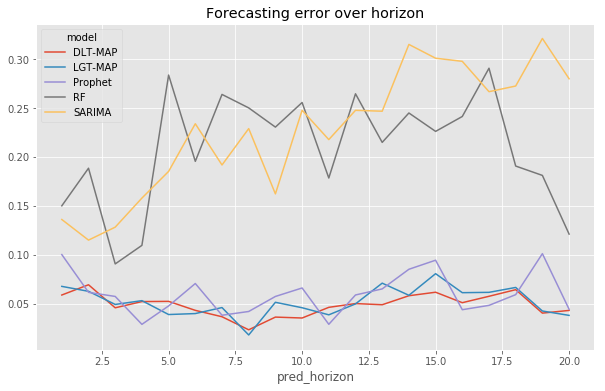

In [43]:
bt_horizon_summary['smape'].pivot(index='pred_horizon', columns='model', values='smape').\
plot(figsize=(10,6), title='Forecasting error over horizon')